# Keras - Time-Series Anomaly Detection

***

## Introduction

Introduce this notebook, set context for what the reader can expect.

***

## Keras & TensorFlow

***

## Keras Time-Series Anomaly.

In [1]:
# Hiding tensorflow warnings. 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Numerical arrays.
import numpy as np

# Spreadsheet like dataframes.
import pandas as pd

# Neural networks.
from tensorflow import keras

# layers pf neural networks.
from tensorflow.keras import layers

# Plotting
from matplotlib import pyplot as plt




<br>

## Data

Explain the links and the dataset
https://www.kaggle.com/datasets/boltzmannbrain/nab

https://github.com/numenta/NAB

<br>


In [3]:
# Root url of data. 
root_url = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

# Data file without anomaly.
no_anomaly_url = root_url + "artificialNoAnomaly/art_daily_small_noise.csv"

# Data file with anomaly.
with_anomaly_url = root_url + "artificialWithAnomaly/art_daily_jumpsup.csv"

<br>

### Reading in file without anomaly.

In [4]:
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

<br>

#### Previewing data without anomaly. 

In [5]:
# Printing the first 5 values.
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


<br>

#### Plotting data with anomaly.

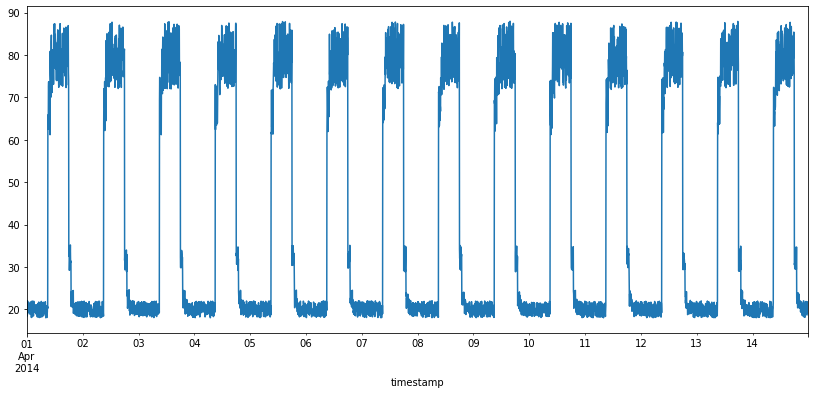

In [6]:
# Plotting as subplot, setting fig size to 14,6.
fig, ax = plt.subplots(figsize =(14,6))

# Plotting dataframe on single axis.  Legend = false as its not useful.
df_small_noise.plot(legend=False, ax=ax);

<br>

### Reading in file with anomaly.

In [7]:
# Reading in file with anomaly.
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

<br>

#### Previewing data with anomaly.

In [8]:
# Previewing file with anomaly. 
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


<br>

#### Plotting data with anomaly.

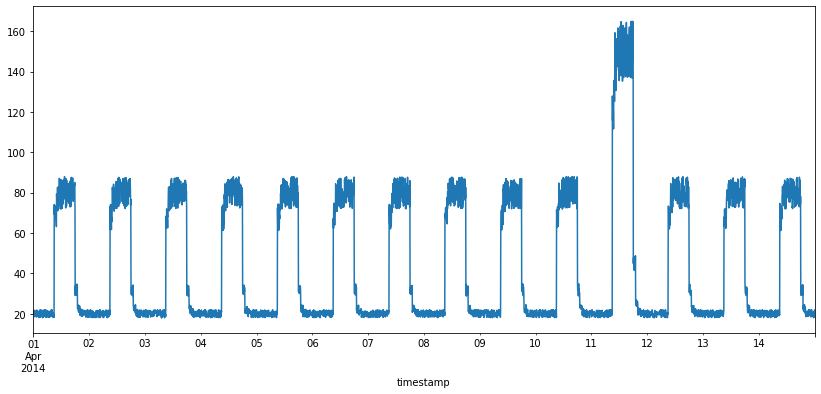

In [9]:
# Plotting as subplot, setting fig size to 14,6.
fig, ax = plt.subplots(figsize =(14,6))

# Plotting dataframe on single axis.  Legend = false as its not useful.
df_daily_jumpsup.plot(legend=False, ax=ax);

<br>

### Pre-processing

<br>

#### Normalising the test data.
<br>

In [10]:
train_mean =  df_small_noise.mean()
train_std = df_small_noise.std()

In [11]:
df_train_vals = (df_small_noise - train_mean) / train_std

df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


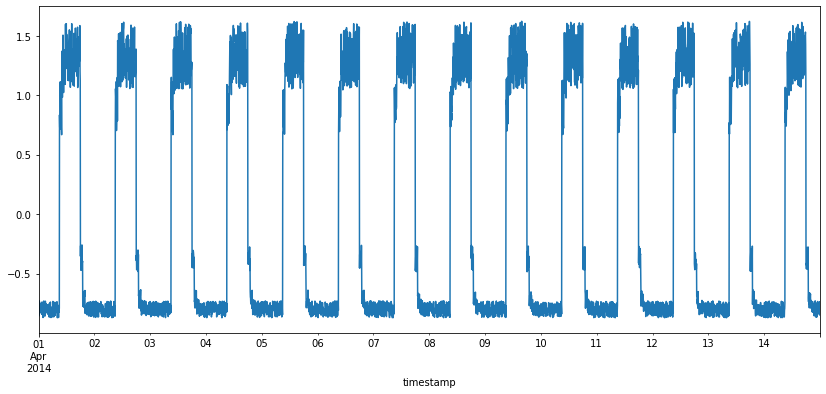

In [12]:
# Plotting as subplot, setting fig size to 14,6.
fig, ax = plt.subplots(figsize =(14,6))

# Plotting dataframe on single axis.  Legend = false as its not useful.
df_train_vals.plot(legend=False, ax=ax);

In [13]:
print("Number of training samples:", df_train_vals.shape[0])

Number of training samples: 4032


In [14]:
windows_size = 288

<br>

Below is a function creates training sequences for use in the model. These are made using sliding windows through the data set. As seen above the data set consists of 4032 values. The size of each window is 288.

In [15]:
def windows(values, N=windows_size):
    
    # start with an empty list
    output = []
    
    # Loop through all the possible windows.
    for i in range(len(values) - N + 1):
        
        # Append each window to the list. 
        output.append(values[i : (i + N)])
    
    # Return the list as stacked arrays.
    return np.stack(output)

In [16]:
x_train = windows(df_train_vals.values)

In [17]:
print (f"As the function iterates through the full data set of {x_train.shape[0]} values, it creates {x_train.shape[0]} possible windows each containing {x_train.shape[1]} values.")

As the function iterates through the full data set of 3745 values, it creates 3745 possible windows each containing 288 values.


<br>

### Neural Network

<br>

Sequential - discuss this function

In [18]:
# Search each method and comment on what it does. 
layers = [
    keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
    keras.layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
    keras.layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
    keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")
]

In [19]:
# building the model. 
model = keras.Sequential(layers)
# optimizer - comment on what this is. 
optimizer=keras.optimizers.Adam(learning_rate=0.001)
# comment on compile and mse. 
model.compile(optimizer=optimizer, loss="mse")
# comment
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [20]:
# sequential - model fit method - history - comment on this and parameters.
# https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit
history = model.fit(
    x_train, # x_train was no anomaly. Used as input and output
    x_train, # He is saying that when he give this as the input, he expects it to be the output. 
    epochs=50, 
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)


Epoch 1/50
27/27 [==============================] - 2s 28ms/step - loss: 0.5323 - val_loss: 0.0824
Epoch 2/50
27/27 [==============================] - 1s 24ms/step - loss: 0.0868 - val_loss: 0.0423
Epoch 3/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0608 - val_loss: 0.0355
Epoch 4/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0506 - val_loss: 0.0310
Epoch 5/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0444 - val_loss: 0.0272
Epoch 6/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0391 - val_loss: 0.0244
Epoch 7/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0350 - val_loss: 0.0229
Epoch 8/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0318 - val_loss: 0.0217
Epoch 9/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0292 - val_loss: 0.0194
Epoch 10/50
27/27 [==============================] - 1s 24ms/step - loss: 0.0272 - val_loss: 0.0191
Epoch 11/

<br>

### Evaluation

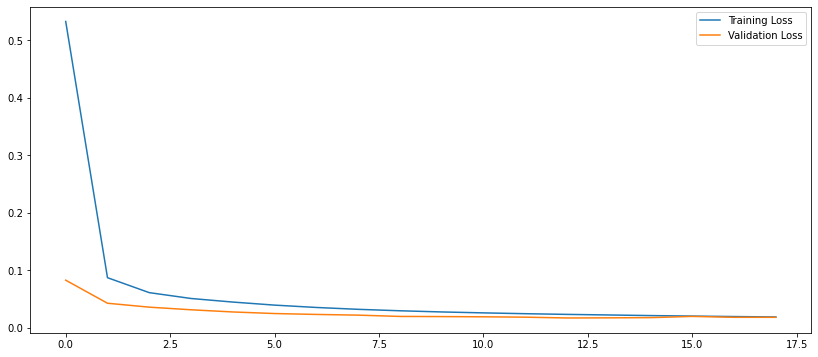

In [21]:
#
fig, ax = plt.subplots(figsize = (14,6))
#
ax.plot(history.history["loss"], label="Training Loss")
#
ax.plot(history.history["val_loss"], label="Validation Loss")
#
ax.legend();

<br>

MAE loss what does this mean. 

In [22]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)

118/118 [==============================] - 1s 3ms/step


In [23]:
# Calculate the loss... 
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

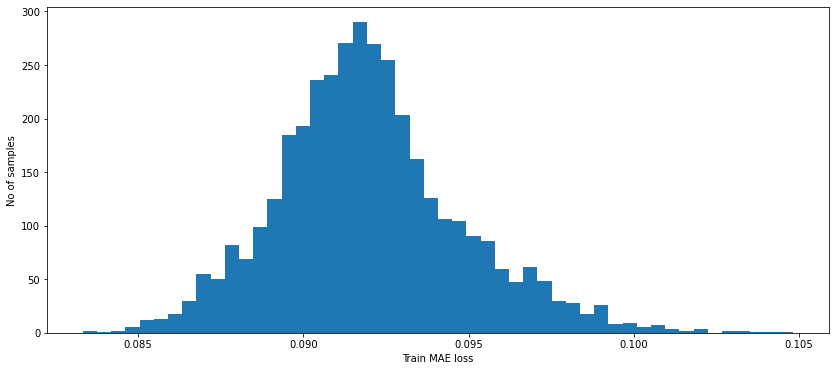

In [24]:
#
fig, ax = plt.subplots(figsize=(14,6))
#
ax.hist(train_mae_loss, bins=50)
#
ax.set_xlabel("Train MAE loss")
#
ax.set_ylabel("No of samples");

In [25]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.10481430221554343


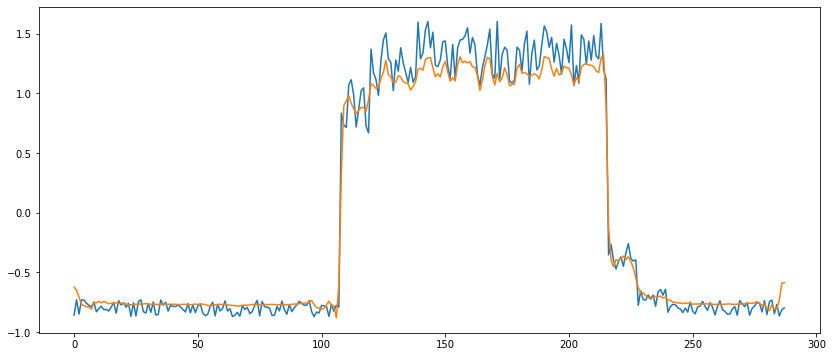

In [26]:
# Checking how the first sequence is learnt
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(x_train[0])
ax.plot(x_train_pred[0]);

In [27]:
#
df_test_value = (df_daily_jumpsup - train_mean) / train_std

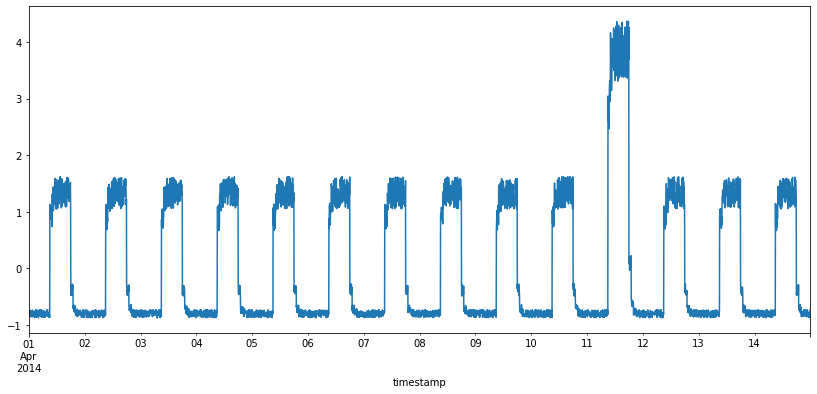

In [28]:
#
fig, ax = plt.subplots(figsize=(14,6))
#
df_test_value.plot(legend=False, ax=ax);

In [29]:
# Create sequences from test values.
x_test = windows(df_test_value.values)

#
print("Test input shape: ", x_test.shape)

Test input shape:  (3745, 288, 1)


In [30]:
# Get test MAE loss. - looked up previously
x_test_pred = model.predict(x_test)

118/118 [==============================] - 0s 3ms/step


In [31]:
#
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

In [32]:
# Reshaped
test_mae_loss = test_mae_loss.reshape((-1))

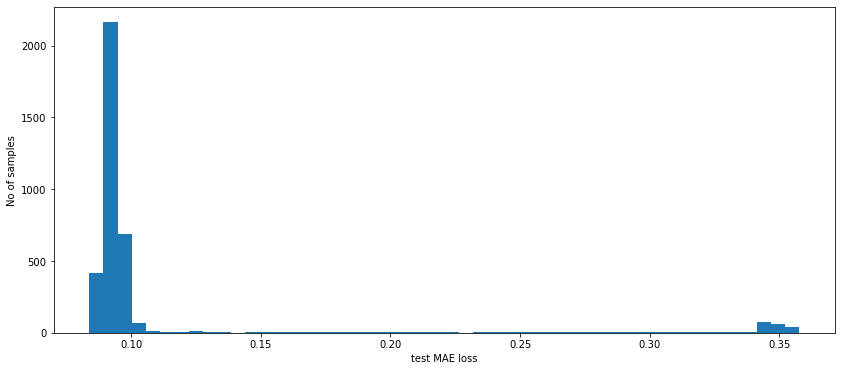

In [33]:
#
fig, ax = plt.subplots(figsize=(14,6))
#
ax.hist(test_mae_loss, bins=50)
#
ax.set_xlabel("test MAE loss")
#
ax.set_ylabel("No of samples"); 

In [34]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# Print number of anomalies 
np.sum(anomalies)

402

In [35]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(windows_size - 1, len(df_test_value) - windows_size + 1):
    if np.all(anomalies[i - windows_size + 1 : i]):
        inds.append(i)

In [37]:
# 
df_subset = df_daily_jumpsup.iloc[inds]

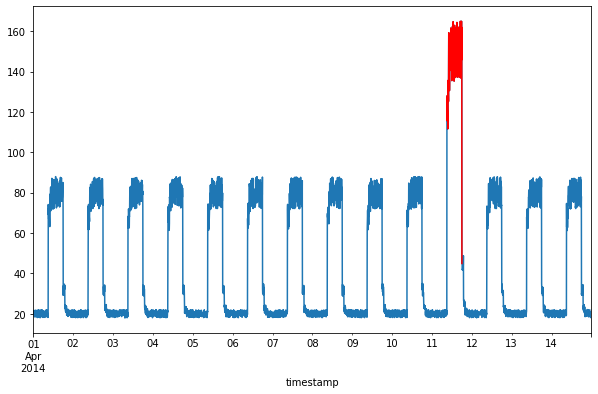

In [38]:
#
fig, ax = plt.subplots(figsize=(10,6))

#
df_daily_jumpsup.plot(legend=False, ax=ax)

#
df_subset.plot(legend=False, ax=ax, color="r"); 

## Conclusion

Suggest improvements I could make to the analysis in this workbook.

***

## References



1. 
2. https://keras.io/examples/timeseries/timeseries_anomaly_detection/
3. 
4. 


## End
***